In [1]:
import os

import torch
import wandb
from hydra import compose, initialize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from src.train.train_bml import BetterBMLTrainer
from src.train.train_bml_alternating import AlternatingBMLTrainer
from src.utils.load import load_dvinp
from src.utils.visualize import visualize_dvinp_both

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
dir = "../models/test" 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    dvinp, optimizer, val_loader, train_loader = load_dvinp(cfg, device)

    dvinp_path = f"{dir}/cdvi.pth"
    optim_path = f"{dir}/optim.pth"

    if os.path.exists(dvinp_path):
        dvinp_state_dict = torch.load(dvinp_path, map_location=torch.device("cpu"), weights_only=True)
        dvinp.load_state_dict(dvinp_state_dict)
        print(f"loaded cdvi from {dvinp_path}")

    if os.path.exists(optim_path):
        optim_state_dict = torch.load(optim_path, map_location=torch.device('cpu'), weights_only=True)
        optimizer.load_state_dict(optim_state_dict)
        print(f"loaded optim from {optim_path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 253013.49it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


In [5]:
wandb_logging = False

if wandb_logging:
    wandb.init(project="test-12345")

In [6]:
# params = [
#     {"params": dvi_process.parameters(), "lr": config.learning_rate},
#     {"params": set_encoder.parameters(), "lr": config.learning_rate},
#     {"params": decoder.parameters(), "lr": config.learning_rate}
# ]

scheduler = None #ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=500)

trainer = BetterBMLTrainer(
    device=device,
    dvinp=dvinp,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    wandb_logging=wandb_logging,
    # num_subtasks=3
)

# trainer = AlternatingBMLTrainer(
#     device=device,
#     cdvi=cdvi,
#     train_decoder_loader=train_loader[0],
#     train_cdvi_loader=train_loader[1],
#     val_loader=val_loader,
#     optimizer=optimizer,
#     wandb_logging=wandb_logging
# )

In [7]:
num_epochs = 100

losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=None, # cfg.training.max_clip_norm,
    alpha=None, # cfg.training.alpha,
    validate=True
)

  0%|          | 0/1 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))
/home/chickencurry/dvi-for-bml/src/utils/grid.py:75: RuntimeWarning: invalid value encountered in divide
  vals = vals / np.sum(vals, axis=-1, keepdims=True)
 25%|██▌       | 8/32 [00:02<00:08,  2.67it/s, epoch=3, loss=197, lmpl=-154, mse=412]Exception ignored in: <generator object tqdm.__iter__ at 0x7f6a50390500>
Traceback (most recent call last):
  File "/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/ho

RuntimeError: Unknown error -2147467259

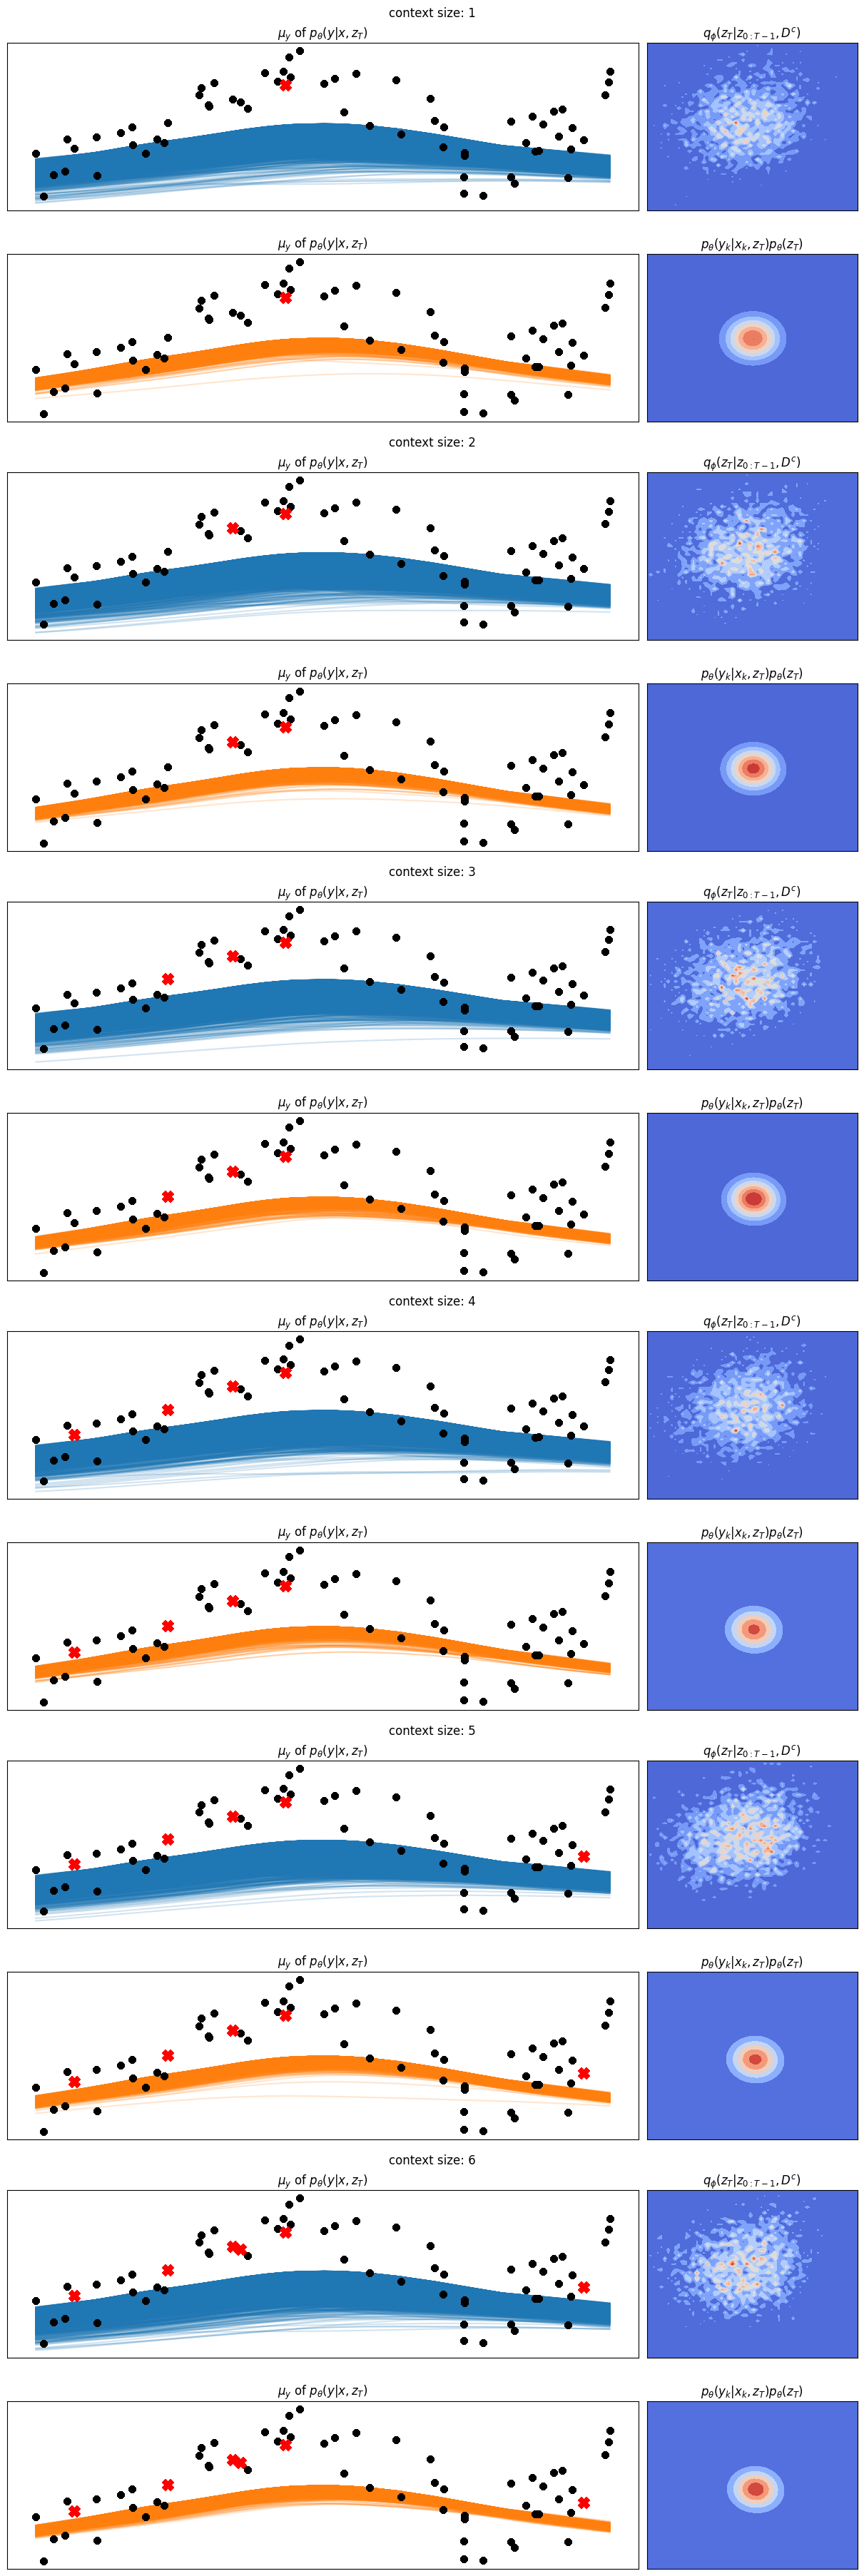

In [8]:
max_context_size = 6
num_samples = 3600 # num_cells will be root
gen_dataloader = DataLoader(val_loader.dataset, 1, True)

ranges = [(-6, 6), (-6, 6)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=gen_dataloader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)

In [ ]:
torch.save(cdvi.state_dict(), f"{dir}/cdvi_finetuned.pth")